For 6 models:

- 20feature-10neuron: asymmetric-normal, noise_var=0.05 -- `cis_asym_norm`
- 20feature-10neuron: symmetric-normal, noise_var=0.05 -- `cis_sym_norm`
- 20feature-10neuron: r=10, noise_var=0.7 -- `cis_rr10`
- 20feature-10neuron: r=2, noise_var=5  -- `cis_rr2`
- 2feature-1neuron: baseline  -- `cis_simple`
- 2feature-1neuron: symmetric-normal, noise_var=0.2  -- `cis_simple_sym`

trained at 2 different $f_p$: [0.1, 0.9]

Classic model viz to plot:

- performances across feature_probs
- onehot input-output heatmap (in=1, in=-1)
- input-output response curves
- adjusted weights per feature (top-left), adjusted weights per neuron (bottom-left), input weights (top-right), output weights (bottom-right)

Additional model viz to plot:

- condition-number of "residual" matrices $r(x)$  => $relu(x) - W_nx$
	- higher learns better?
- singular-value spectra of different $r(x)$ across a held-out batch
	- visualize effective ranks -- lower learns better?
- align $W_2$ rows with $W_n$ eigenvectors and plot dot-products.
	- in better learned case, a few neurons cover many directions?

*note*: show that the noise matrix can also let the model do better at the expense of comp in soup

In [ ]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from collections import defaultdict
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from scipy.stats import describe, kstest, mannwhitneyu, sem
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis import plot, util

In [3]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 14})

In [4]:
"""Set torch device."""

# device = t.device("cpu")  # small toy models may be faster via cpu
device = t.device("cuda" if t.cuda.is_available() else "cpu")
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA GeForce RTX 3090'


In [2]:
sns.set_style("whitegrid")

plt.rcParams.update({"font.size": 14})
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.title_fontsize"] = 13

## Training the models

In [5]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(
    model: Cis,
    batch_sz: int, 
    sparsity: float | Float[Tensor, "inst feat"],
    device: t.device
) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
    device: t.device
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.6f}"})
    
    return losses

@t.no_grad()
def eval_model(
    model: Cis, 
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    n_batches: int,
    device: t.device
):
    losses = t.zeros(n_batches)
    
    for b in range(n_batches):
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        losses[b] = loss_fn(y, y_true, 1)
    
    return losses

In [18]:
"""Set up and train models."""

feat_sparsity = 0.9
feat_prob = 1 - feat_sparsity
layer_act_fns = [t.relu, lambda x: x]
batch_sz = 1024
n_steps = 10000
logging_freq = n_steps // 10

In [19]:
# - 20feature-10neuron: asymmetric-normal, noise_var=0.05
noise_params = {
    "matrix_type": "asymmetric",
    "noise_coeff": 0.05,
}
cis_asym_norm_cfg = CisConfig(
    n_instances=1,
    n_feat=20,
    n_hidden=10,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_asym_norm = Cis(cis_asym_norm_cfg, device=device).to(device)
optimizer = optim.Adam(cis_asym_norm.parameters(), lr=1e-3)
_losses = train(
    model=cis_asym_norm,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
eval_losses = eval_model(
    cis_asym_norm, 
    batch_sz=100000,  # 1000000 
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

naive_loss = (
    1/6 
    * (cis_asym_norm_cfg.n_feat - cis_asym_norm_cfg.n_hidden) / cis_asym_norm_cfg.n_feat
    * feat_prob
)
print(f"naive loss: {naive_loss:.2e}")

eval loss: 7.59e-03
naive loss: 8.33e-03


In [21]:
# - 20feature-10neuron: symmetric-normal, noise_var=0.05
noise_params = {
    "matrix_type": "symmetric",
    "noise_coeff": 0.05,
}
cis_sym_norm_cfg = CisConfig(
    n_instances=1,
    n_feat=20,
    n_hidden=10,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_sym_norm = Cis(cis_sym_norm_cfg, device=device).to(device)
optimizer = optim.Adam(cis_sym_norm.parameters(), lr=1e-3)
_losses = train(
    model=cis_sym_norm,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
eval_losses = eval_model(
    cis_sym_norm, 
    batch_sz=100000,  # 1000000 
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

naive_loss = (
    1/6 
    * (cis_asym_norm_cfg.n_feat - cis_asym_norm_cfg.n_hidden) / cis_asym_norm_cfg.n_feat 
    * feat_prob
)
print(f"naive loss: {naive_loss:.2e}")

eval loss: 6.96e-03
naive loss: 8.33e-03


In [23]:
# - 20feature-10neuron: r=10, noise_var=0.7
noise_params = {
    "matrix_type": "rank-r",  # "asymmetric", "rank-r"
    "noise_coeff": 0.7,
    "r": 10
}
cis_rr10_cfg = CisConfig(
    n_instances=1,
    n_feat=20,
    n_hidden=10,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_rr10 = Cis(cis_rr10_cfg, device=device).to(device)
optimizer = optim.Adam(cis_rr10.parameters(), lr=1e-3)
_losses = train(
    model=cis_rr10,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
eval_losses = eval_model(
    cis_rr10, 
    batch_sz=100000,  # 1000000 
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

naive_loss = (
    1/6 
    * (cis_rr10_cfg.n_feat - cis_rr10_cfg.n_hidden) / cis_rr10_cfg.n_feat 
    * feat_prob
)
print(f"naive loss: {naive_loss:.2e}")

eval loss: 6.26e-03
naive loss: 8.33e-03


In [25]:
# - 20feature-10neuron: r=2, noise_var=5
noise_params = {
    "matrix_type": "rank-r",  # "asymmetric", "rank-r"
    "noise_coeff": 5,
    "r": 2
}
cis_rr2_cfg = CisConfig(
    n_instances=1,
    n_feat=20,
    n_hidden=10,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_rr2 = Cis(cis_rr2_cfg, device=device).to(device)
optimizer = optim.Adam(cis_rr2.parameters(), lr=1e-3)
_losses = train(
    model=cis_rr2,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:
eval_losses = eval_model(
    cis_rr2, 
    batch_sz=100000,  # 1000000 
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

naive_loss = (
    1/6 
    * (cis_rr2_cfg.n_feat - cis_rr2_cfg.n_hidden) / cis_rr2_cfg.n_feat 
    * feat_prob
)
print(f"naive loss: {naive_loss:.2e}")

eval loss: 6.44e-03
naive loss: 8.33e-03


In [28]:
# - 2feature-1neuron: baseline
cis_simple_cfg = CisConfig(
    n_instances=1,
    n_feat=2,
    n_hidden=1,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)
cis_simple = Cis(cis_simple_cfg, device=device).to(device)
optimizer = optim.Adam(cis_simple.parameters(), lr=1e-3)
_losses = train(
    model=cis_simple,
    batch_sz=128,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=4000,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

In [29]:
eval_losses = eval_model(
    cis_simple, 
    batch_sz=10000,
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

naive_loss = (
    1/6
    * (cis_simple_cfg.n_feat - cis_simple_cfg.n_hidden) / cis_simple_cfg.n_feat
    * feat_prob
)
print(f"naive loss: {naive_loss:.2e}")

eval loss: 8.14e-03
naive loss: 8.33e-03


In [36]:
# - 2feature-1neuron: symmetric-normal, noise_var=0.2
noise_params = {
    "matrix_type": "symmetric",
    "noise_coeff": 0.2,
}
cis_simple_sym_cfg = CisConfig(
    n_instances=1,
    n_feat=2,
    n_hidden=1,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_simple_sym = Cis(cis_simple_sym_cfg, device=device).to(device)
optimizer = optim.Adam(cis_simple_sym.parameters(), lr=1e-3)
_losses = train(
    model=cis_simple_sym,
    batch_sz=128,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=4000,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

In [37]:
eval_losses = eval_model(
    cis_simple_sym, 
    batch_sz=100000,  # 1000000 
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

naive_loss = (
    1/6
    * (cis_simple_sym_cfg.n_feat - cis_simple_sym_cfg.n_hidden) / cis_simple_sym_cfg.n_feat
    * feat_prob
)
print(f"naive loss: {naive_loss:.2e}")

eval loss: 5.47e-03
naive loss: 8.33e-03


## Model Viz

### p=0.1

#### Performance across feature_probs

Testing across feature sparsities:   0%|          | 0/19 [00:00<?, ?it/s]

Testing across feature sparsities: 100%|██████████| 19/19 [00:00<00:00, 20.77it/s]


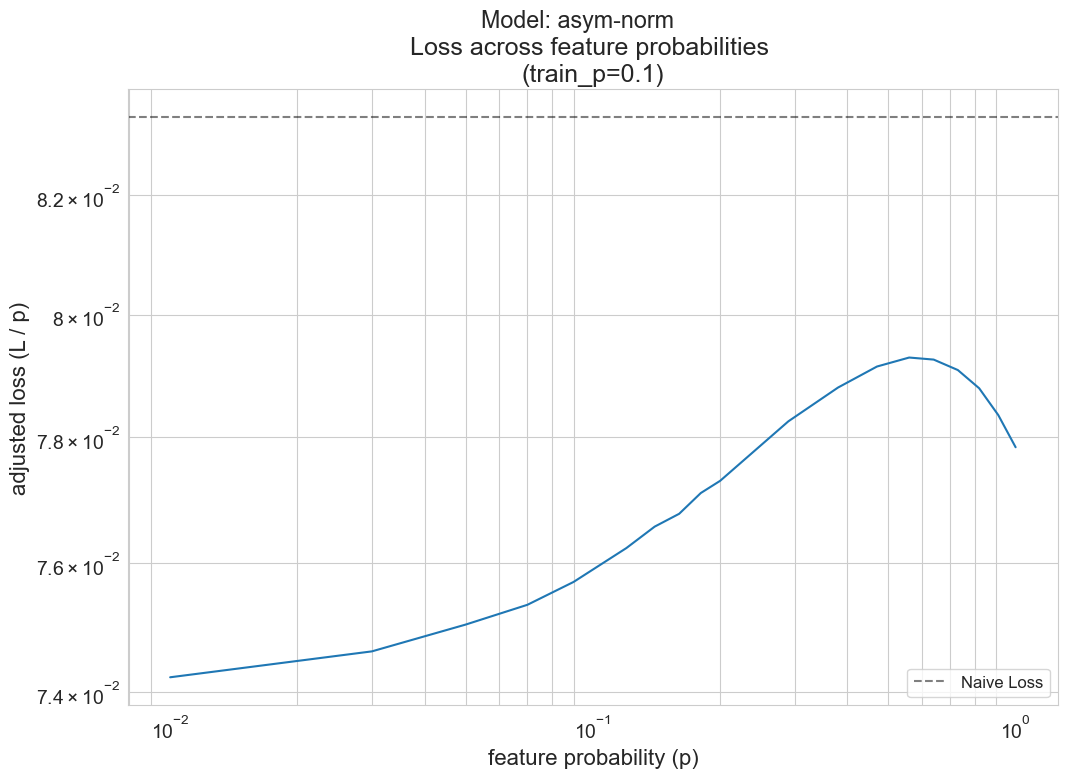

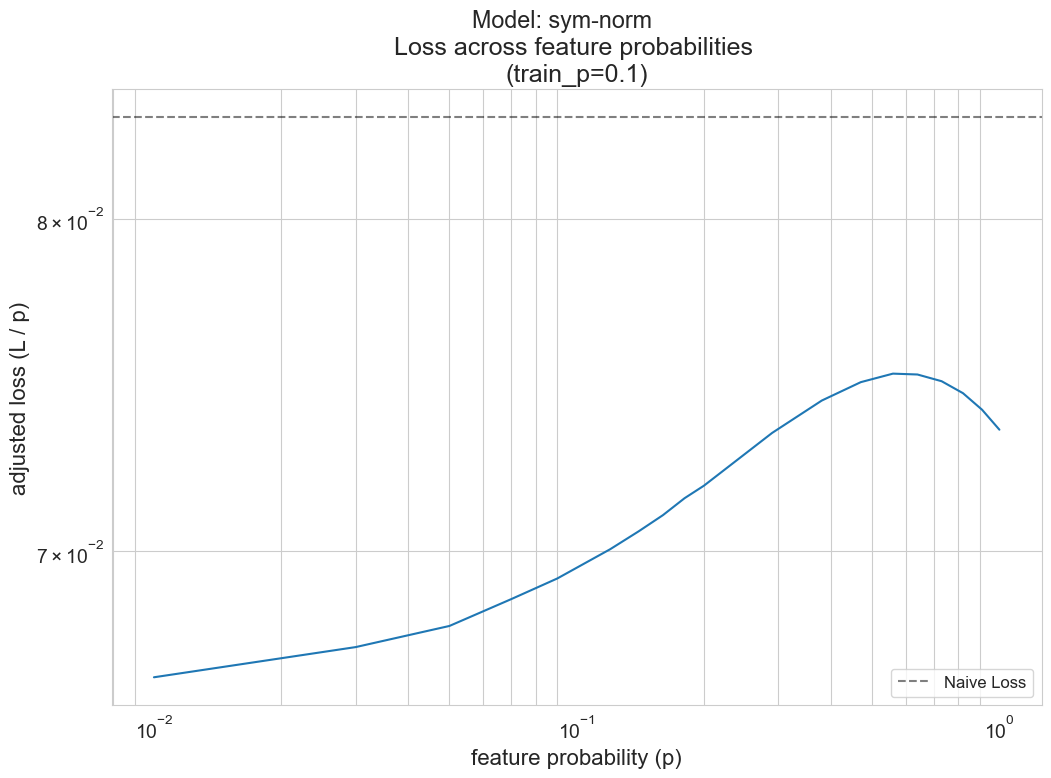

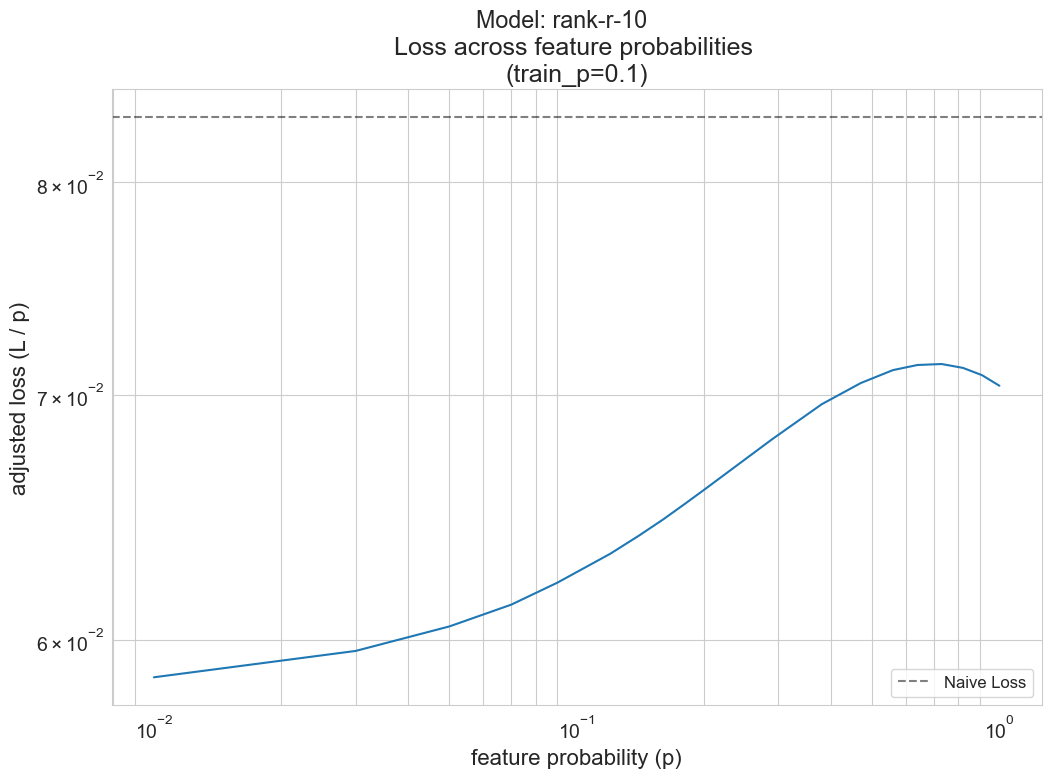

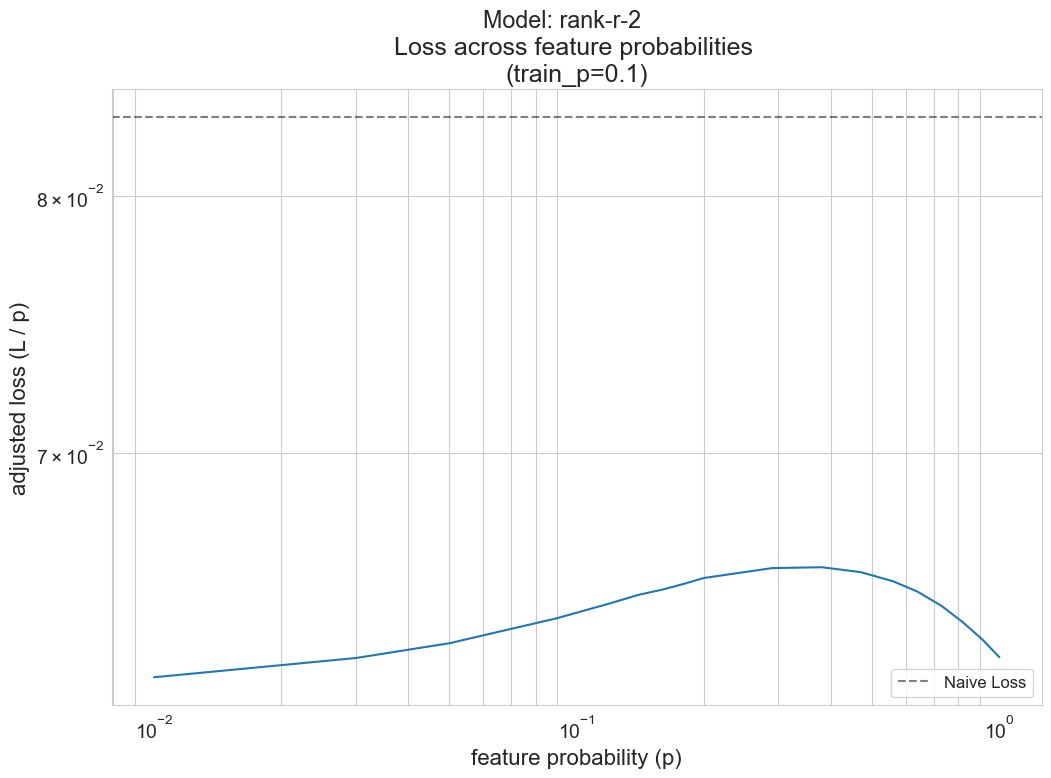

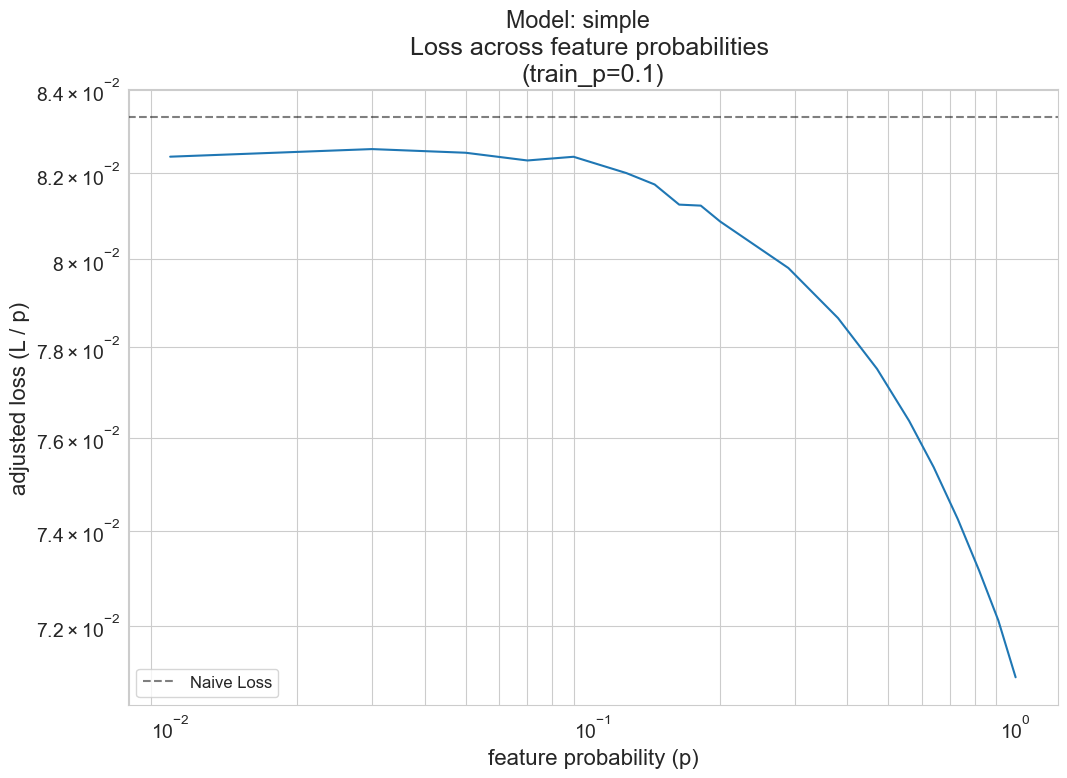

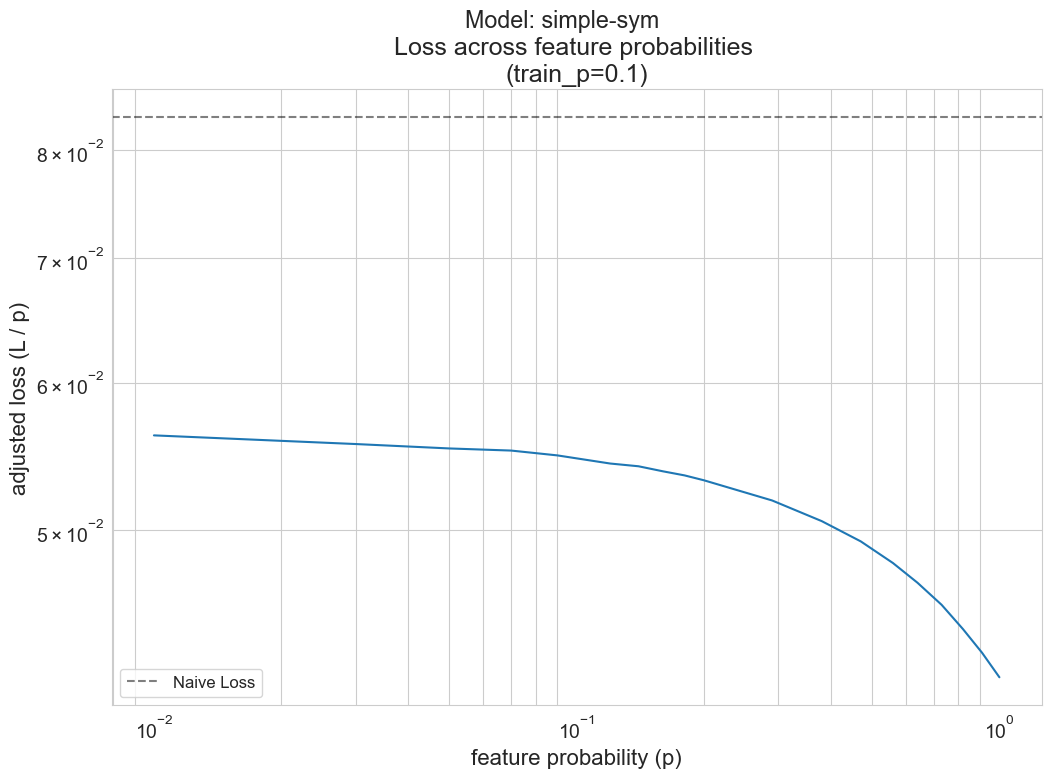

In [59]:
models = [cis_asym_norm, cis_sym_norm, cis_rr10, cis_rr2, cis_simple, cis_simple_sym]
model_names = ["asym-norm", "sym-norm", "rank-r-10", "rank-r-2", "simple", "simple-sym"]

sparsity_low = np.round(np.linspace(0.0, 0.8, 10), 2)
sparsity_high = np.round(np.linspace(0.8, 0.99, 10), 2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))

for model, name in zip(models, model_names):
    ax, _ = plot.plot_loss_across_sparsities(
        sparsities=sparsities,
        model=model,
        eval_model=eval_model,
        train_sparsity=feat_sparsity,
    )
    ax.figure.suptitle(f"Model: {name}")
    ax.grid(which="both", axis="both")

#### Input-Output


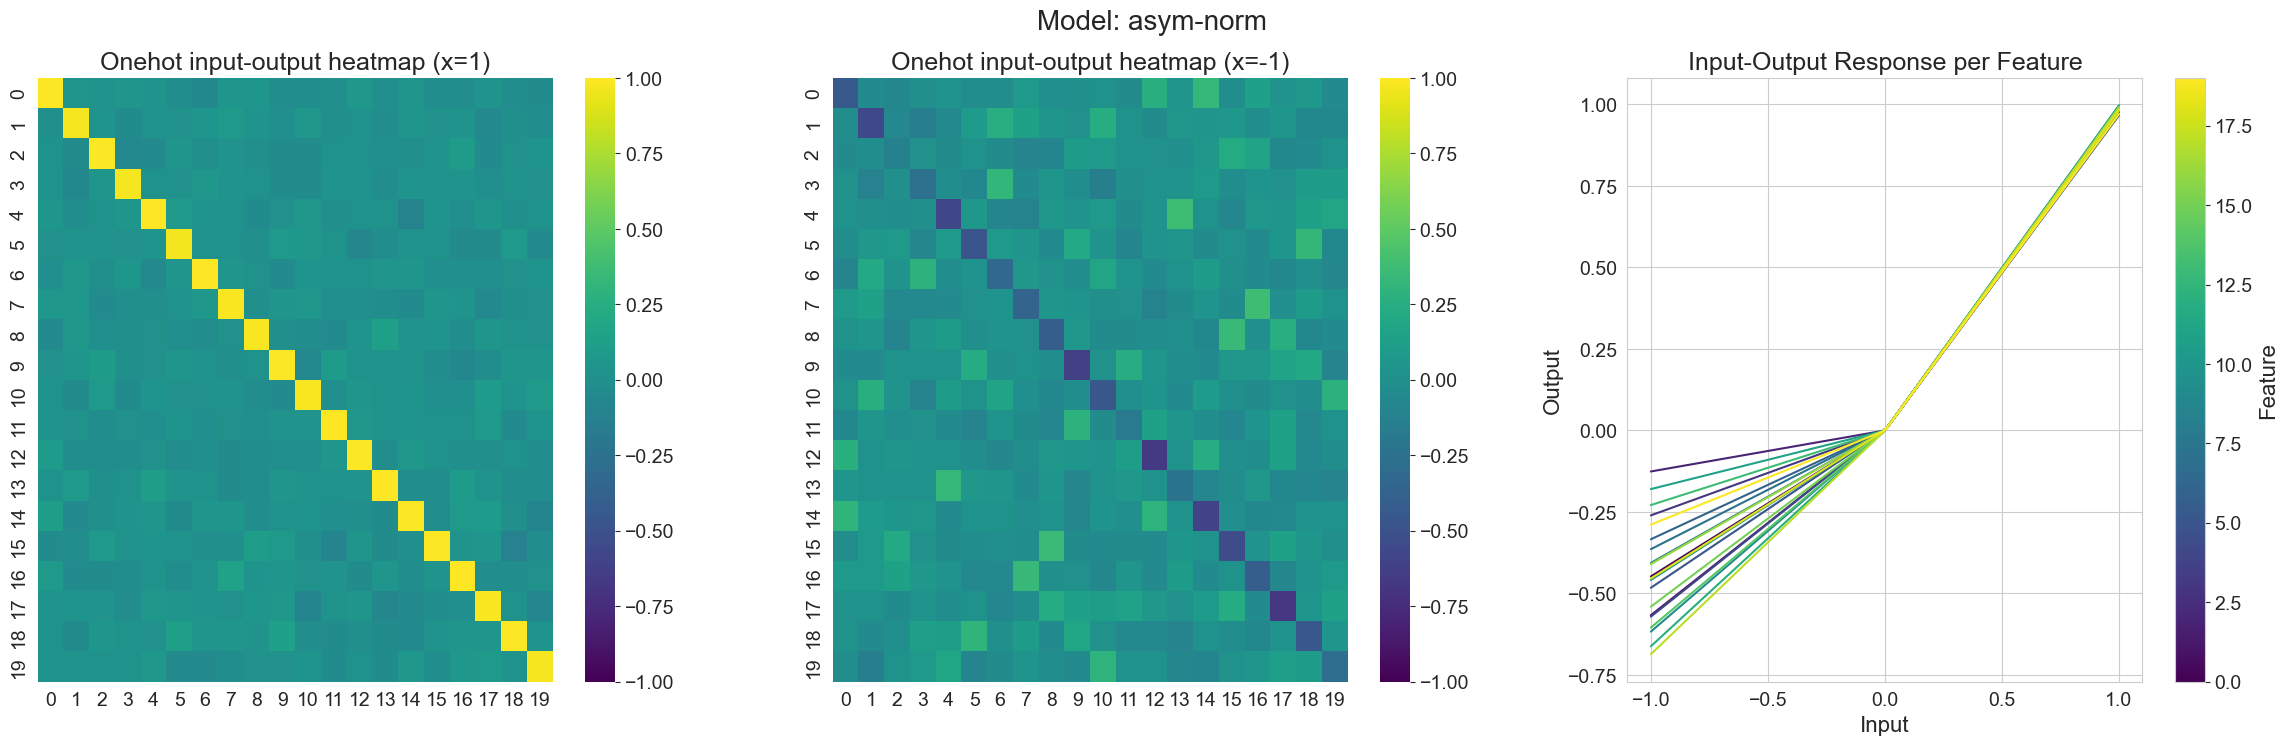

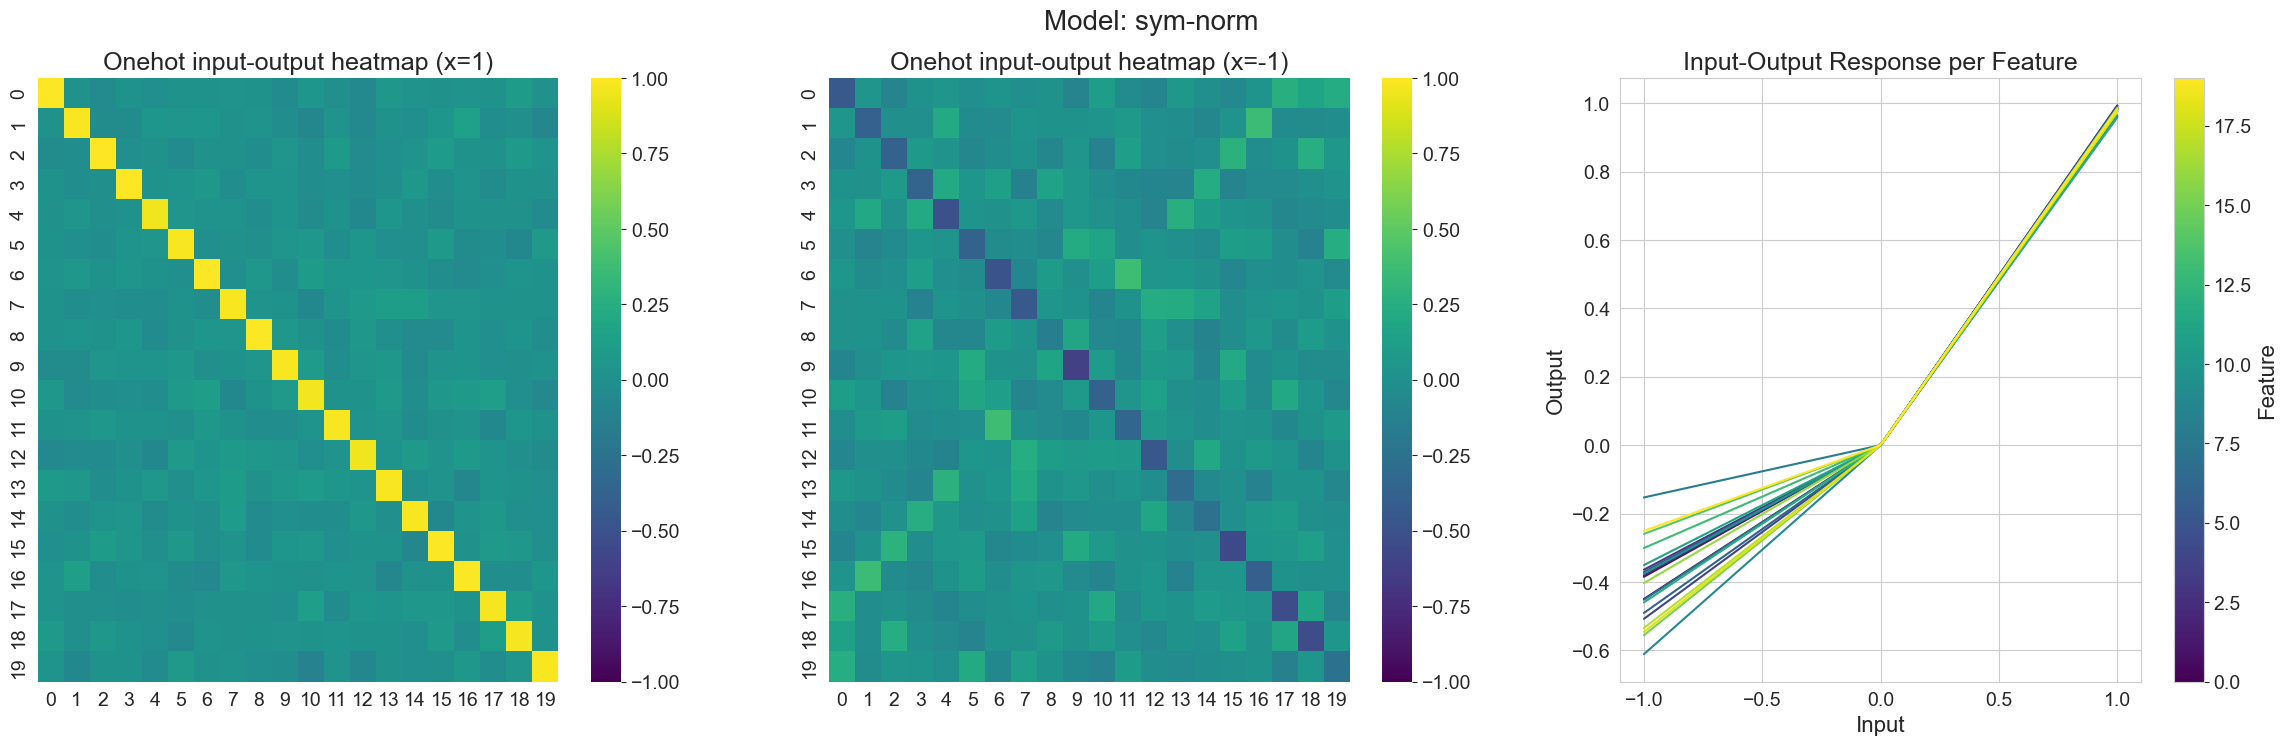

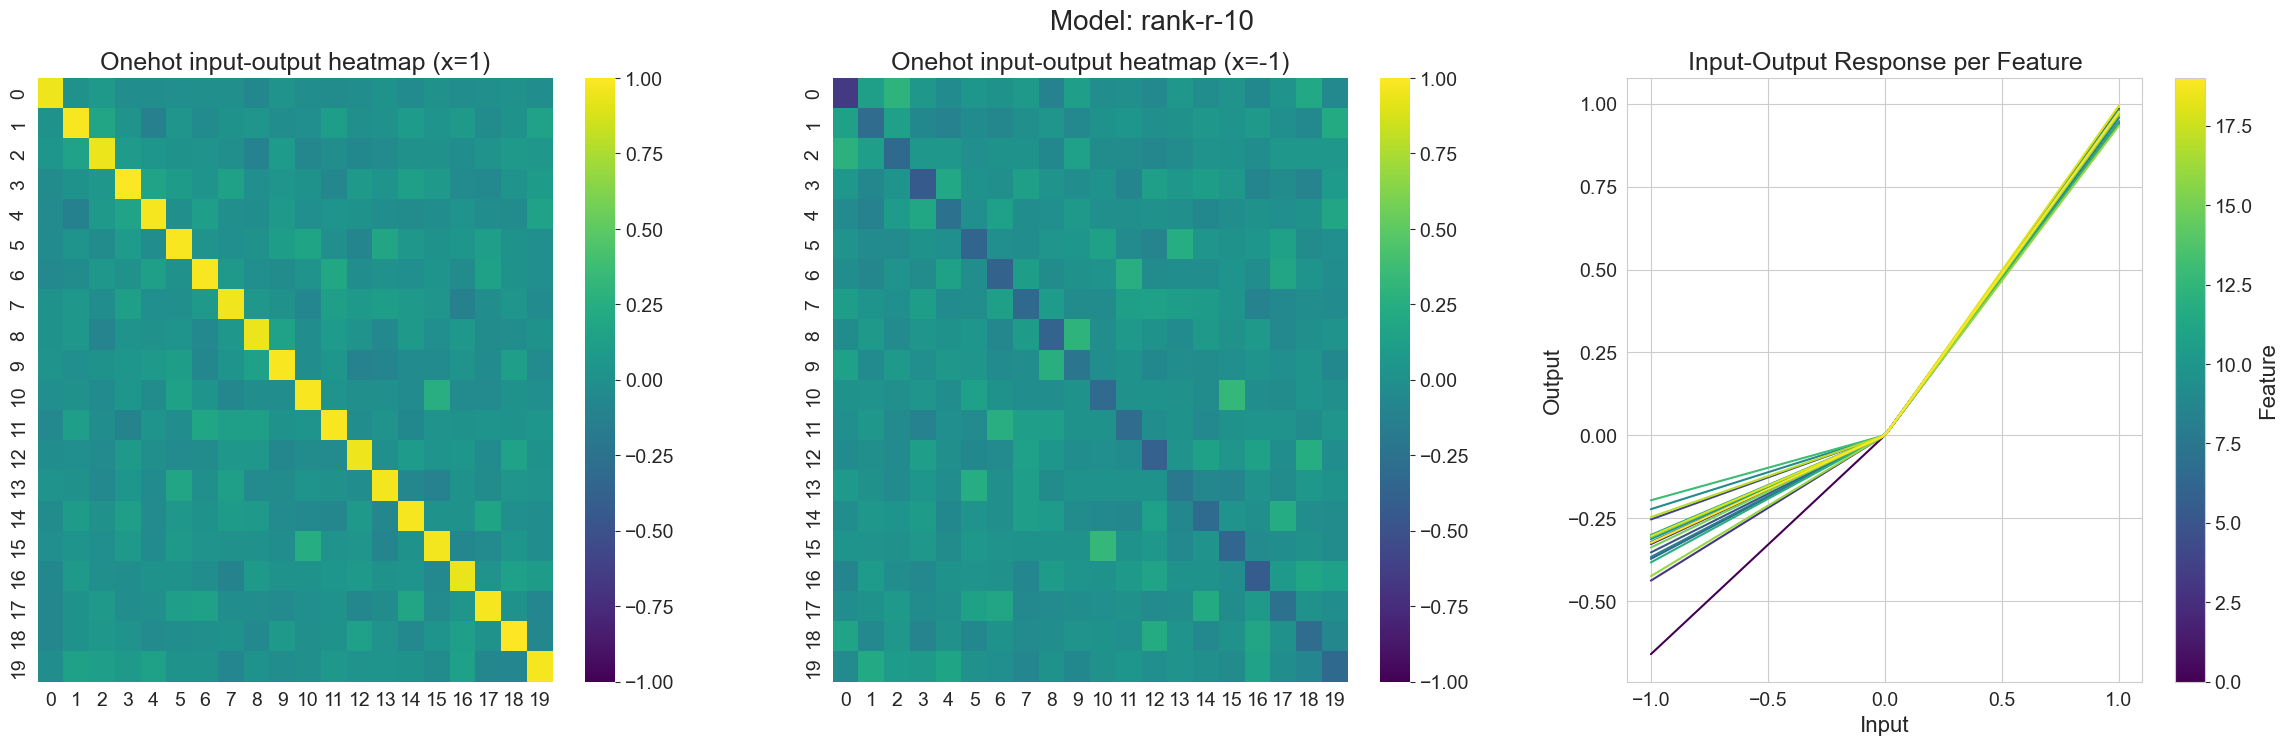

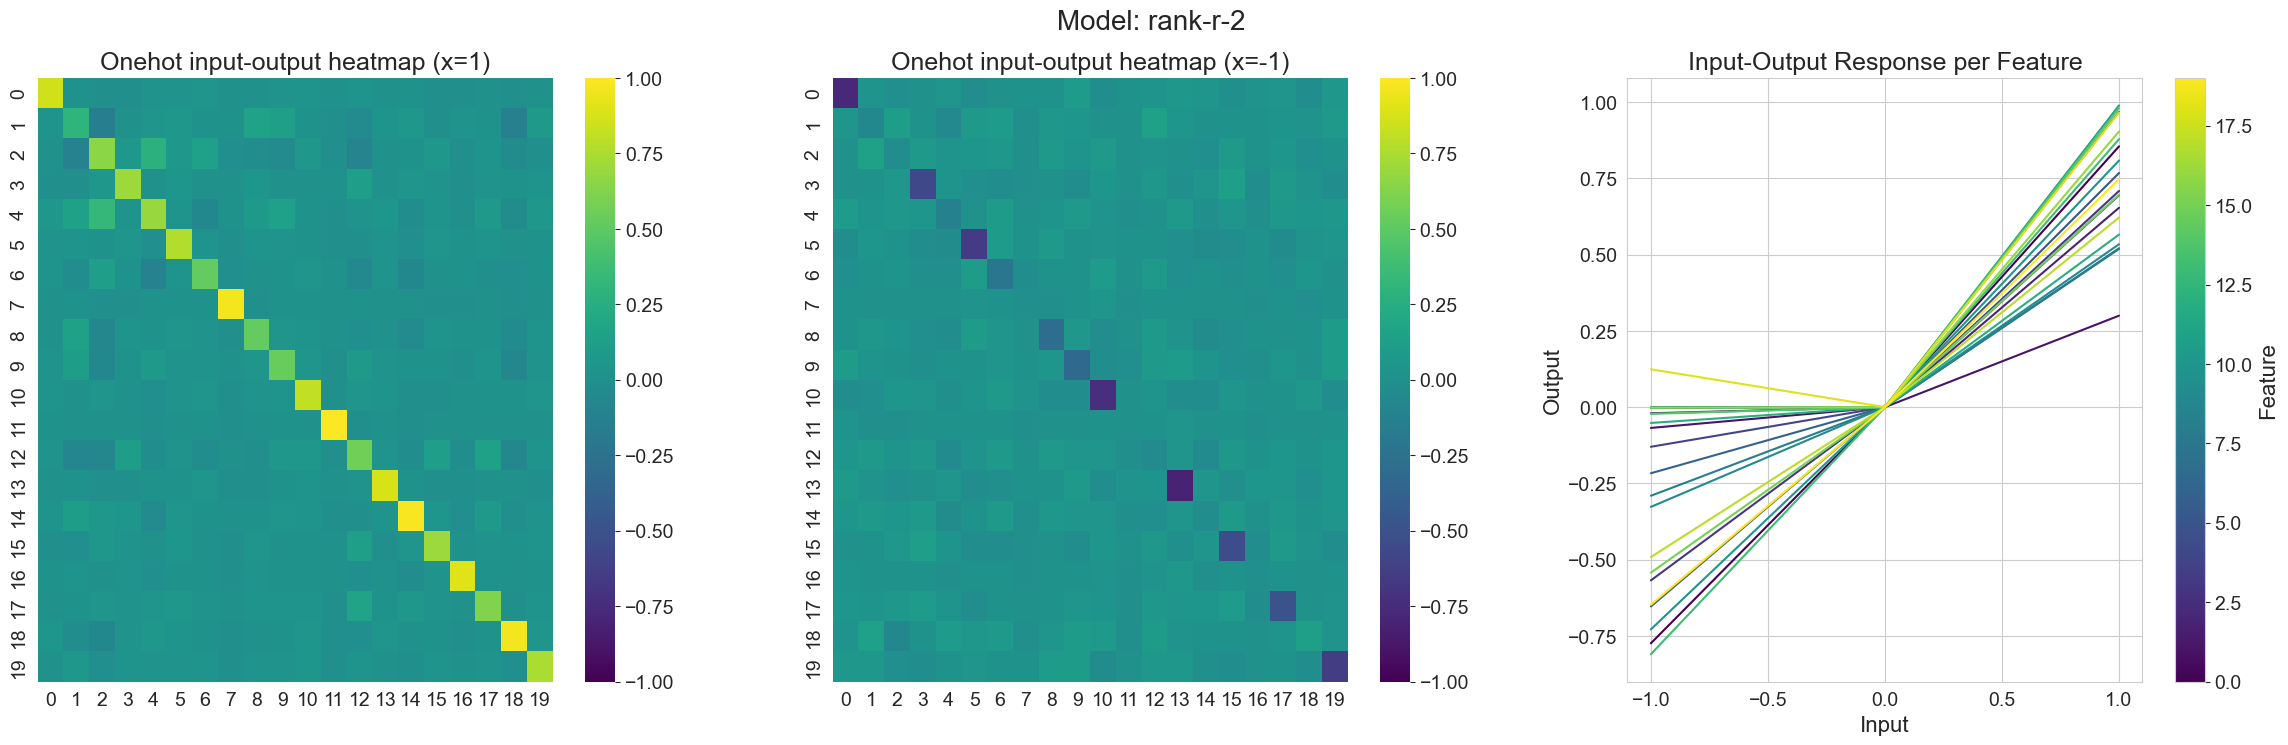

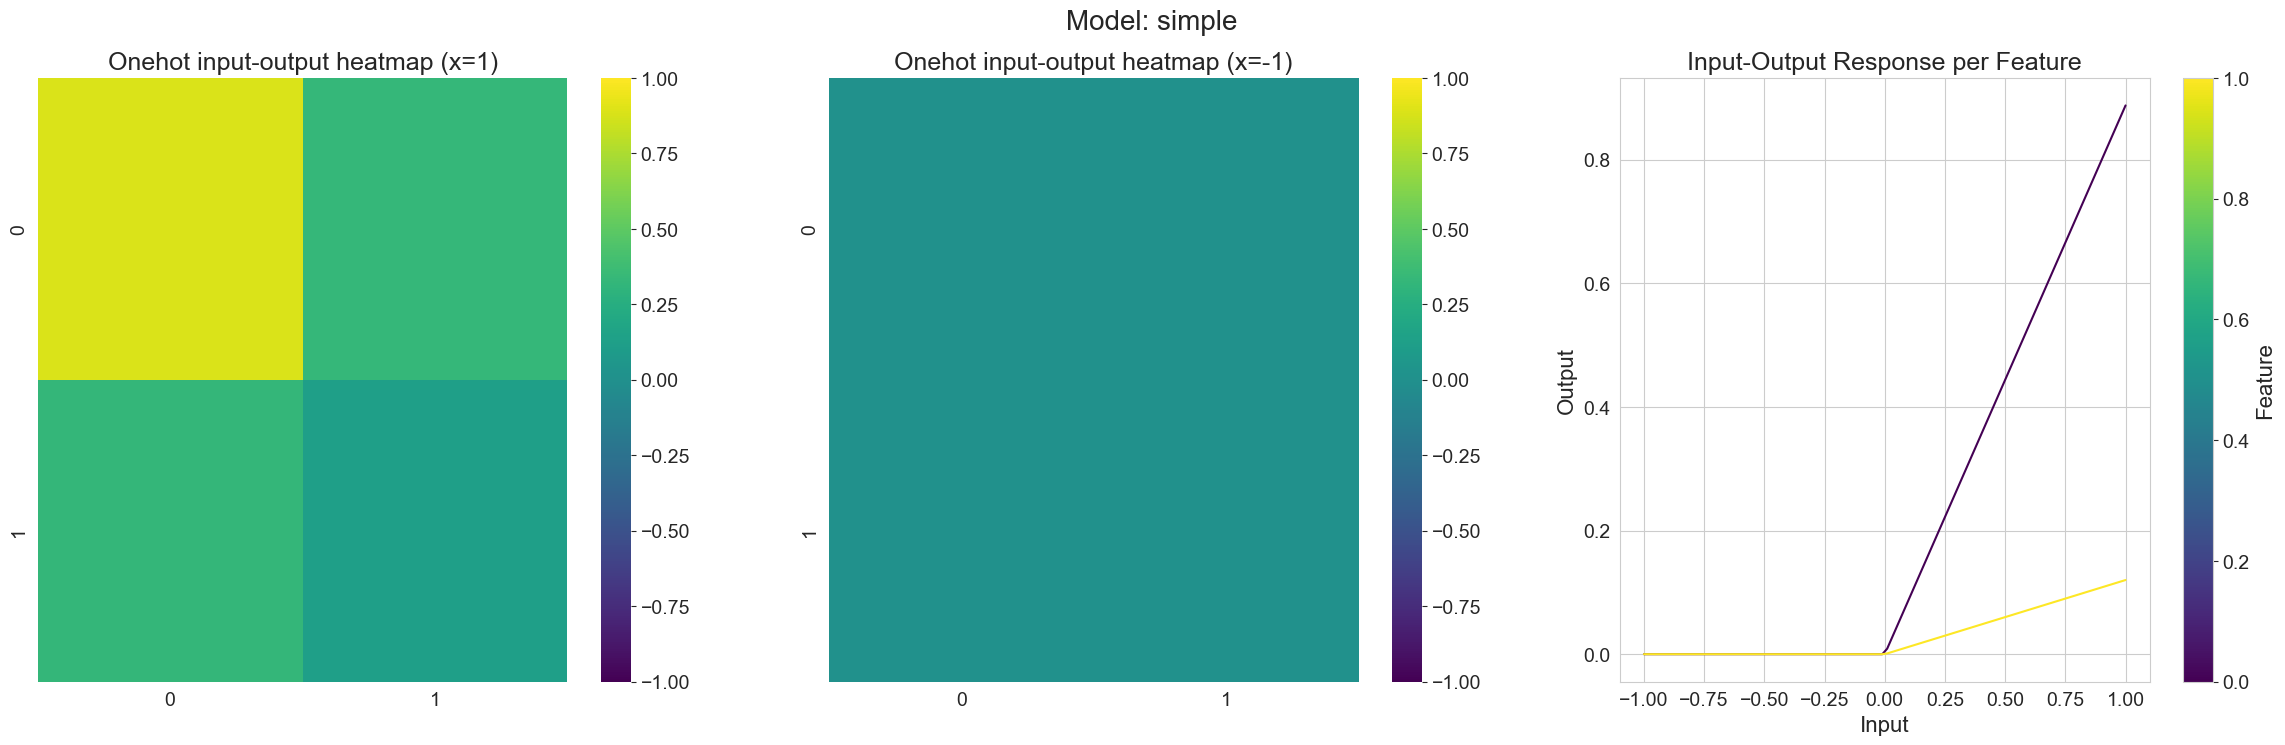

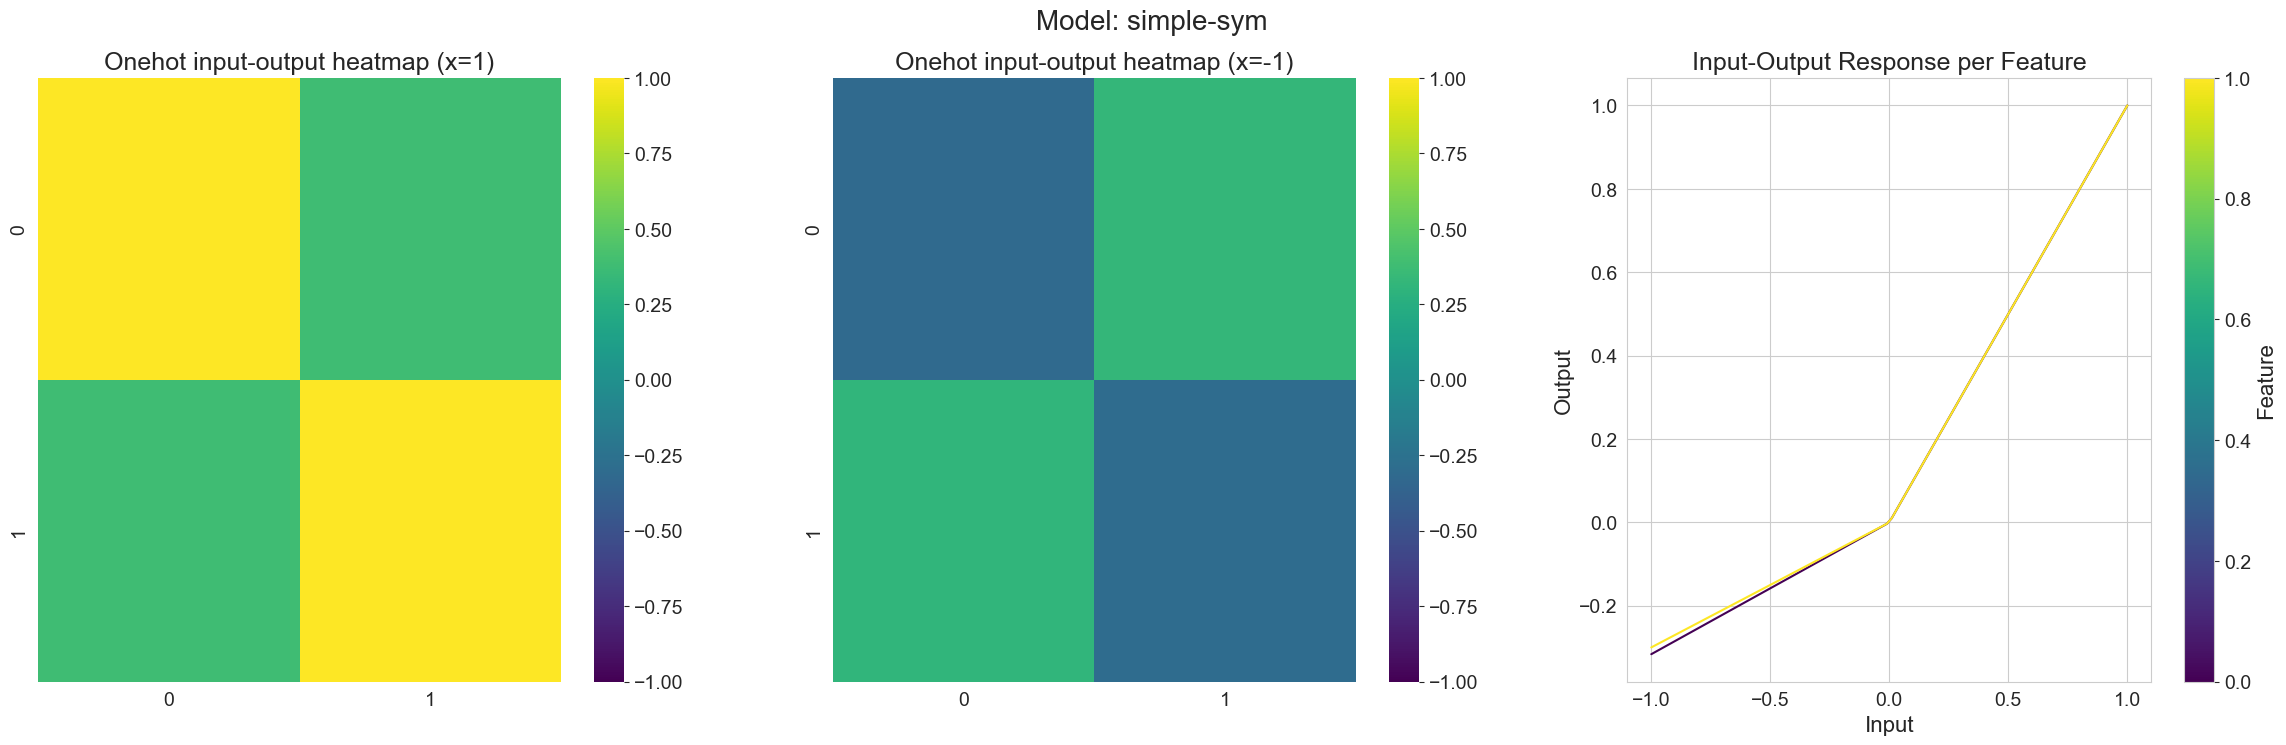

In [83]:
for model, model_name in zip(models, model_names):
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    
    plot.plot_input_output_heatmap(1, model, ax=axs[0], annot=False)
    plot.plot_input_output_heatmap(-1, model, ax=axs[1], annot=False)
    x = t.linspace(-1, 1, 100, device=device)
    Y = util.in_out_response(model, x, device=device)
    plot.plot_input_output_response(Y, x, list(range(model.cfg.n_feat)), ax=axs[2])
    
    fig.tight_layout(pad=3)
    fig.suptitle(f"Model: {model_name}", fontsize=20)

#### Weights


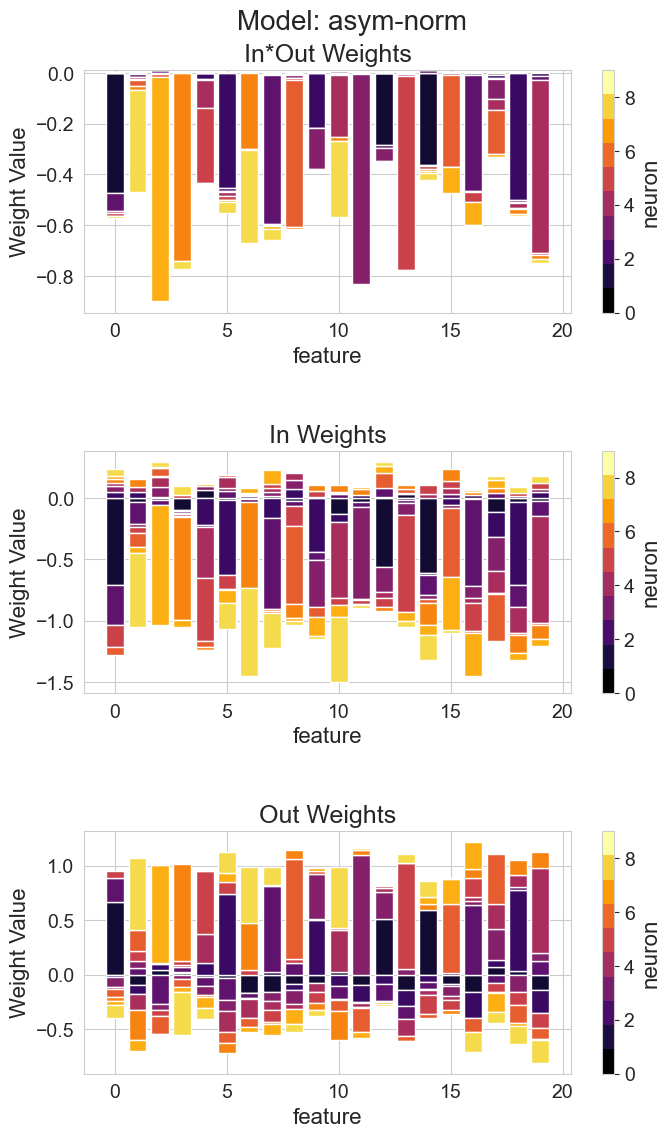

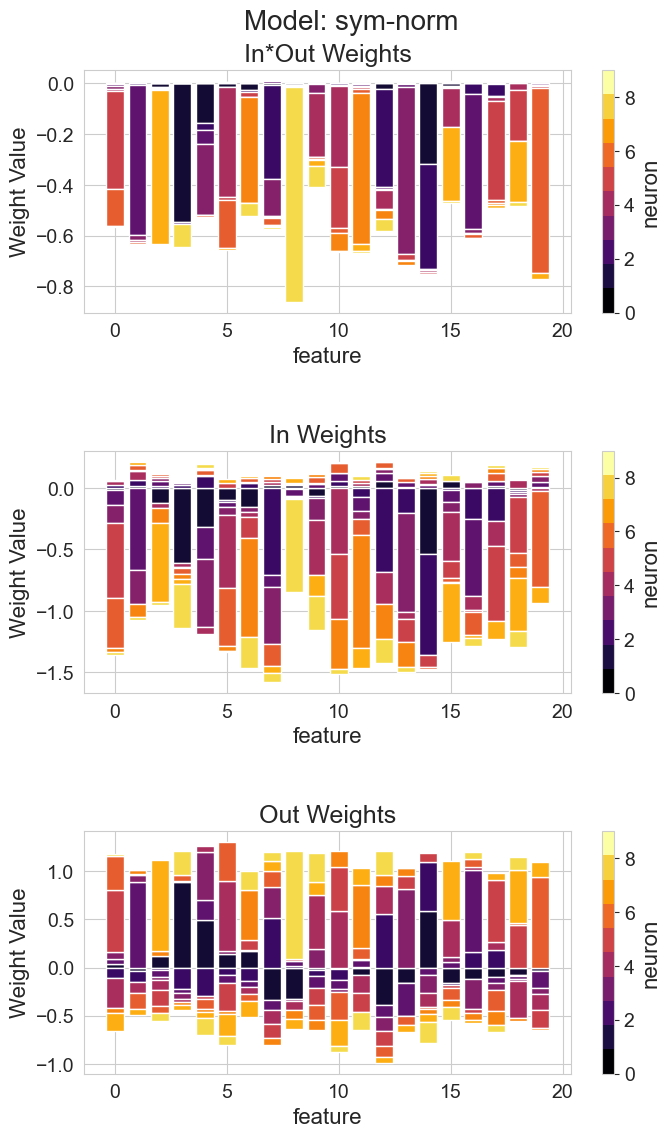

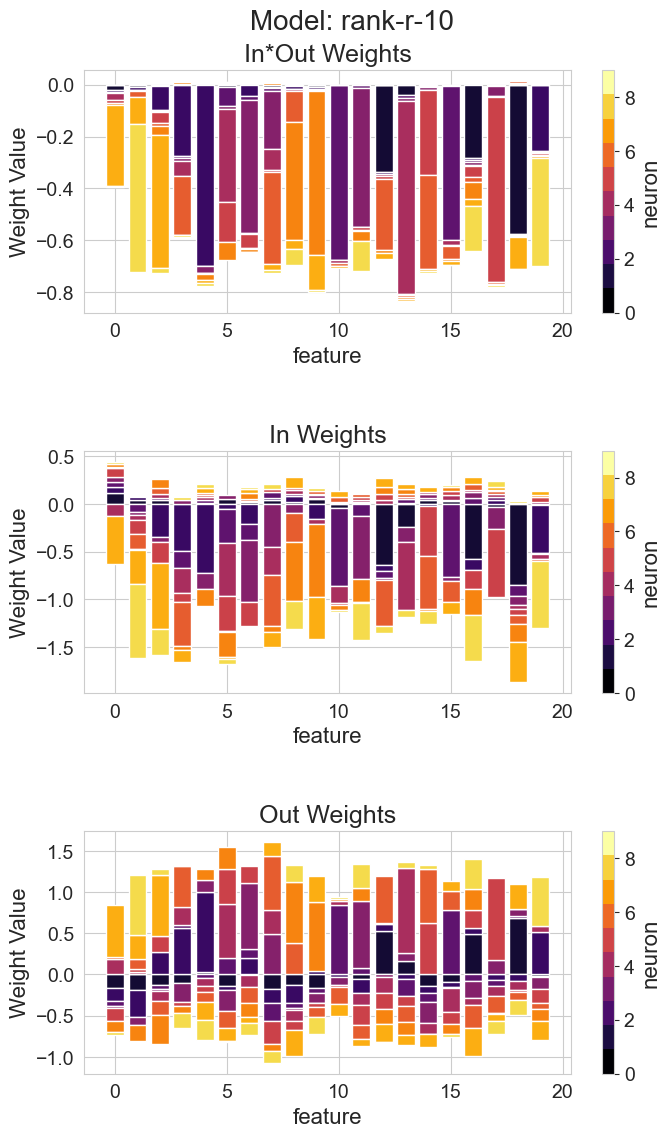

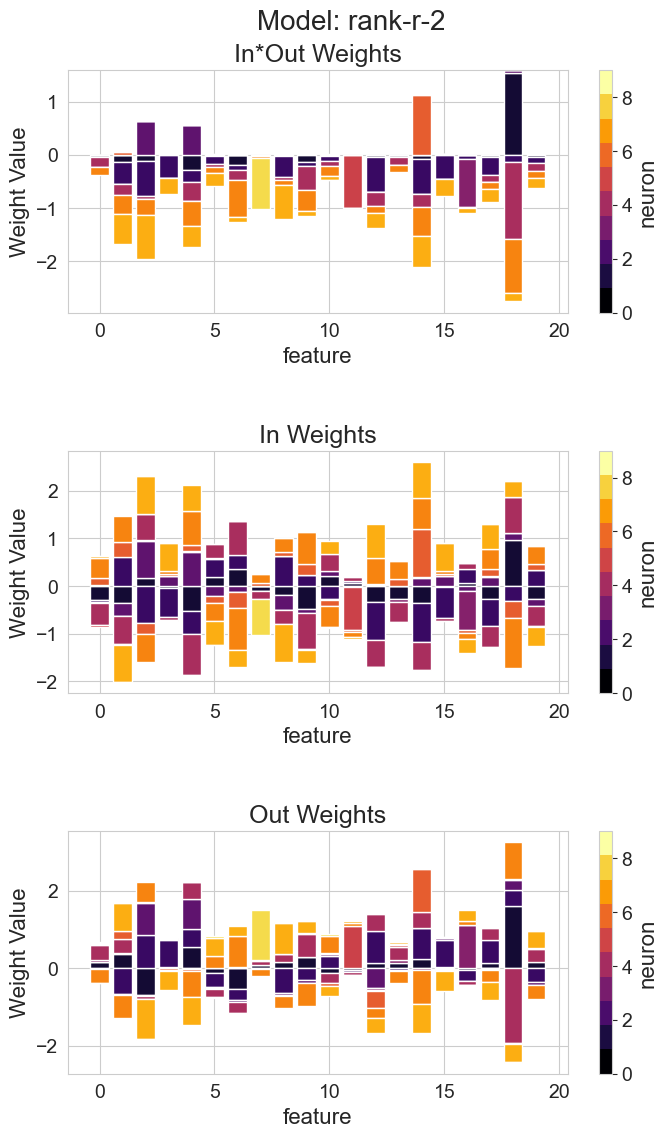

In [89]:
for model, model_name in zip(models[:-2], model_names[:-2]):
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    W_adj = einsum(model.W1, model.W2, "inst dmlp feat, inst feat dmlp -> dmlp feat")
    W_adj = util.threshold_matrix(W_adj, threshold=0.001)
    plot.plot_weight_bars(W_adj, xax="feature", ax=axs[0])
    axs[0].set_title("In*Out Weights")
    plot.plot_weight_bars(
        util.threshold_matrix(model.W1.squeeze(), threshold=0.001), xax="feature", ax=axs[1]
    )
    axs[1].set_title("In Weights")
    plot.plot_weight_bars(
        util.threshold_matrix(model.W2.squeeze().T, threshold=0.001), xax="feature", ax=axs[2]
    )
    axs[2].set_title("Out Weights")

    fig.tight_layout(pad=3)
    fig.suptitle(f"Model: {model_name}", fontsize=20)

#### Condition number and Singular Value spectra of $r(x)$

In [136]:
sns.set_style("white")

In [143]:
x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)
relu_x_k = np.linalg.cond(asnumpy(relu_x.squeeze())).item()
print(f"{relu_x_k=:.3f}")
relu_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
sv_dict = {"relu": relu_sv}

for model, model_name in zip(models[:-2], model_names[:-2]):
    # Get residual target values (res_target) for a test batch
    Wnx = einsum(model.Wn, x, "inst feat feat_out, batch inst feat -> batch inst feat_out")
    res_target = relu_x - Wnx
    
    # Get condition number of residual target.. 
    res_target_k = np.linalg.cond(asnumpy(res_target.squeeze())).item()
    print(f"{res_target_k=:.3f} : {model_name=}")

    # Get singular values of residual target.
    res_sv = t.linalg.svdvals(res_target.squeeze()).sort(descending=True).values
    sv_dict[model_name] = res_sv


relu_x_k=1.807
res_target_k=1.968 : model_name='asym-norm'
res_target_k=2.402 : model_name='sym-norm'
res_target_k=2.463 : model_name='rank-r-10'
res_target_k=11.097 : model_name='rank-r-2'


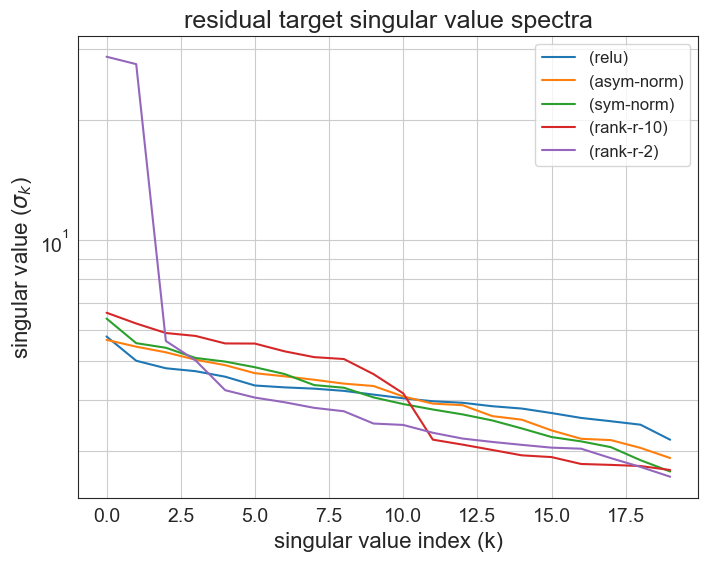

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i, (model_name, sv_values) in enumerate(sv_dict.items()):
    ax.semilogy(
        asnumpy(sv_values), 
        label=f"({model_name})",
        # linestyle=linestyles[i % len(linestyles)],
        # color=colors[i % len(colors)]
    )

ax.set_xlabel("singular value index (k)")
ax.set_ylabel(r"singular value ($\sigma_k$)")
ax.set_title("residual target singular value spectra")
ax.legend()
ax.grid(which="both", axis="both")

# Expectation: steeper decay of singular values = effectively lower rank = easier to learn

#### Dot-products of $W_2$ neurons with $W_n$ eigenvectors


In [146]:
projs

tensor([[0.1091, 0.1396, 0.0352, 0.0211, 0.0235, 0.0299, 0.0817, 0.1111, 0.0028,
         0.0668],
        [0.1858, 0.0556, 0.0400, 0.1626, 0.1459, 0.1102, 0.0681, 0.1393, 0.1670,
         0.1030],
        [0.0907, 0.1290, 0.0409, 0.0464, 0.0717, 0.0933, 0.0728, 0.0810, 0.3083,
         0.0396],
        [0.0863, 0.0179, 0.0517, 0.0652, 0.0395, 0.0760, 0.3499, 0.0604, 0.2279,
         0.0713],
        [0.0997, 0.1059, 0.2747, 0.0645, 0.0091, 0.2440, 0.0187, 0.0055, 0.0622,
         0.0193],
        [0.0480, 0.2414, 0.0717, 0.0372, 0.2178, 0.0431, 0.0126, 0.0847, 0.3558,
         0.1776],
        [0.3149, 0.1039, 0.1178, 0.3196, 0.1105, 0.0922, 0.0653, 0.2470, 0.2265,
         0.0137],
        [0.3158, 0.1576, 0.1008, 0.5105, 0.1893, 0.0192, 0.0011, 0.3303, 0.0275,
         0.1889],
        [0.0681, 0.2368, 0.0398, 0.2127, 0.1630, 0.0475, 0.2088, 0.1565, 0.1429,
         0.3319],
        [0.3014, 0.0928, 0.0035, 0.1090, 0.3311, 0.2353, 0.6624, 0.2031, 0.0980,
         0.1694],
        [0

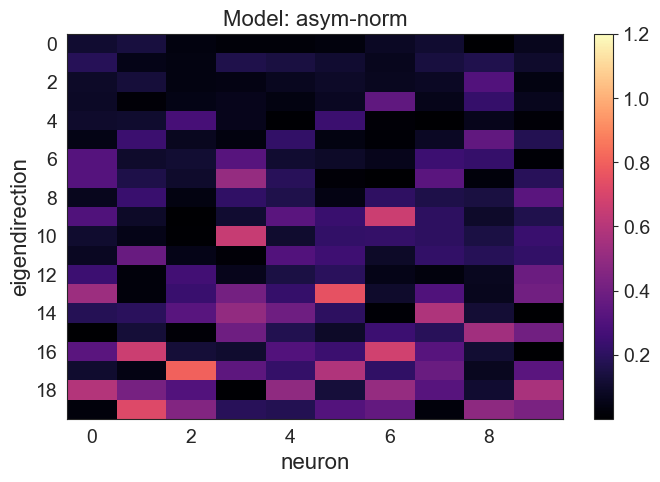

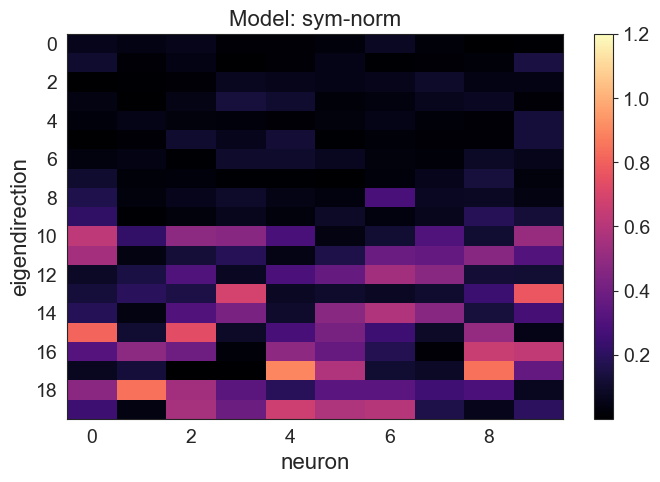

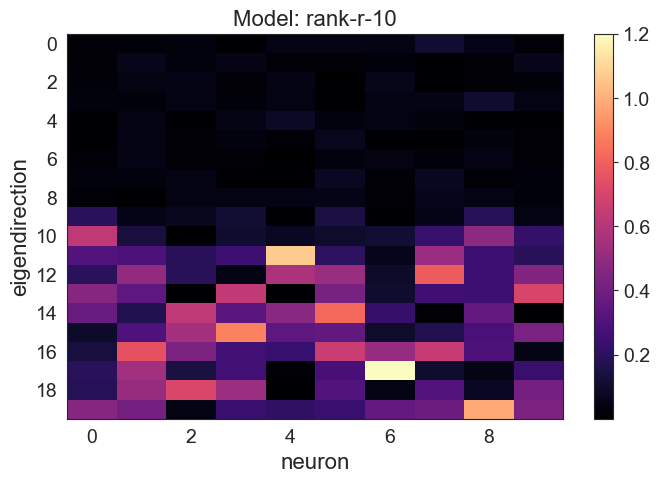

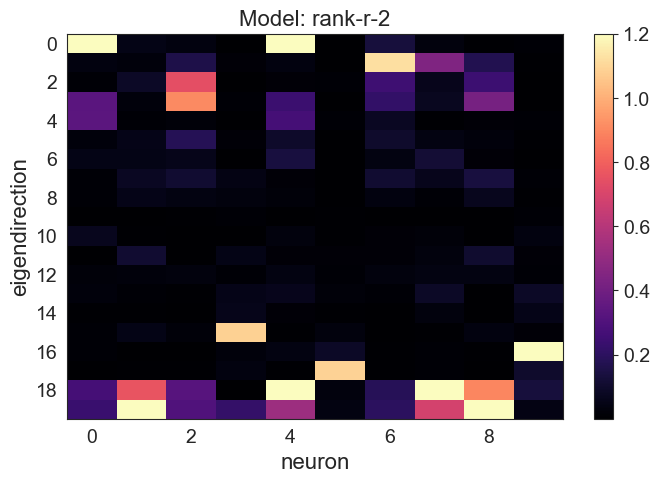

In [149]:
for model, model_name in zip(models[:-2], model_names[:-2]):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Get eigenvectors of Wn for this model
    _eigvals, U = t.linalg.eigh(model.Wn.squeeze())
    
    # Compute dot-product magnitudes between eigenvectors and output weights
    projs = t.abs(U.T @ model.W2.squeeze())  # [feat, hid] dot-product magnitudes
    
    # Create heatmap on the axis
    im = ax.imshow(asnumpy(projs), aspect="auto", cmap="magma", vmax=1.2)
    
    ax.set_yticks(np.arange(0, 20, 2))
    ax.set_xlabel("neuron")
    ax.set_ylabel("eigendirection")
    ax.set_title(f"Model: {model_name}", fontsize=16)
    cbar = fig.colorbar(im, ax=ax)
    
    # Expectation: higher-value but fewer bright streaks = fewer neurons cover many eigen-directions = effectively lower rank = easier to learn

### p=0.9

#### Performance across feature_probs

#### Input-Output


#### Weights


#### Singular Value spectra of $r(x)$

#### Dot-products of $W_2$ neurons with $W_n$ eigenvectors


Questions:

- What is the optimal noise given a particular model? Can we solve for this analytically?